In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings
np.__version__


'1.23.1'

In [2]:

pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

print(pdb)
print(files)


data\pentapeptide-impl-solv.pdb
['data\\pentapeptide-00-500ns-impl-solv.xtc', 'data\\pentapeptide-01-500ns-impl-solv.xtc', 'data\\pentapeptide-02-500ns-impl-solv.xtc', 'data\\pentapeptide-03-500ns-impl-solv.xtc', 'data\\pentapeptide-04-500ns-impl-solv.xtc', 'data\\pentapeptide-05-500ns-impl-solv.xtc', 'data\\pentapeptide-06-500ns-impl-solv.xtc', 'data\\pentapeptide-07-500ns-impl-solv.xtc', 'data\\pentapeptide-08-500ns-impl-solv.xtc', 'data\\pentapeptide-09-500ns-impl-solv.xtc', 'data\\pentapeptide-10-500ns-impl-solv.xtc', 'data\\pentapeptide-11-500ns-impl-solv.xtc', 'data\\pentapeptide-12-500ns-impl-solv.xtc', 'data\\pentapeptide-13-500ns-impl-solv.xtc', 'data\\pentapeptide-14-500ns-impl-solv.xtc', 'data\\pentapeptide-15-500ns-impl-solv.xtc', 'data\\pentapeptide-16-500ns-impl-solv.xtc', 'data\\pentapeptide-17-500ns-impl-solv.xtc', 'data\\pentapeptide-18-500ns-impl-solv.xtc', 'data\\pentapeptide-19-500ns-impl-solv.xtc', 'data\\pentapeptide-20-500ns-impl-solv.xtc', 'data\\pentapeptide-21

In [3]:

torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']


100%|██████████| 25/25 [00:02<00:00, 12.36it/s]                                 


In [4]:

def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores



C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roa

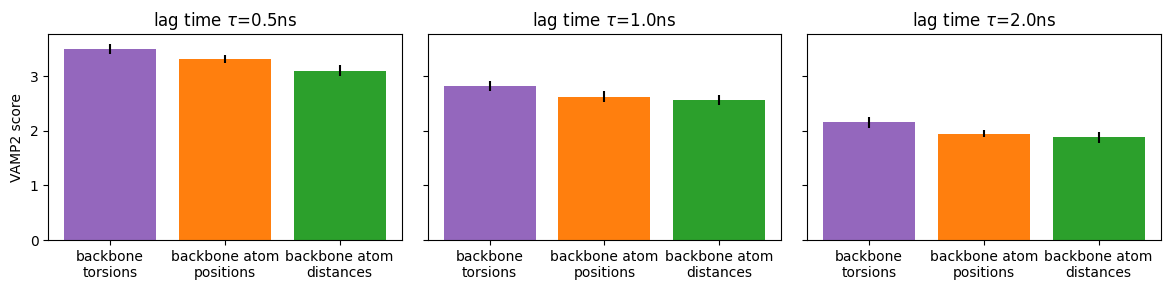

In [5]:

dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C4', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roa

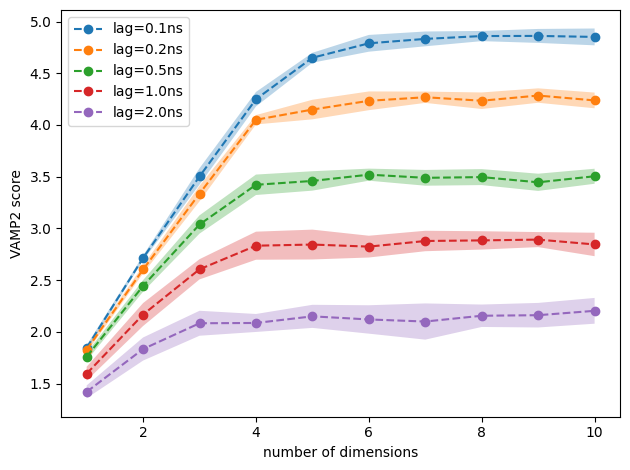

In [6]:

lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(torsions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [7]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 25/25 [00:00<00:00, 1041.78it/s]             


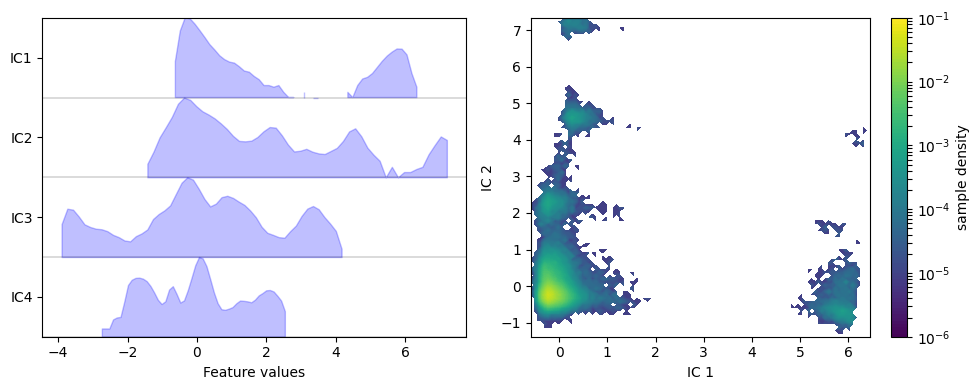

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()


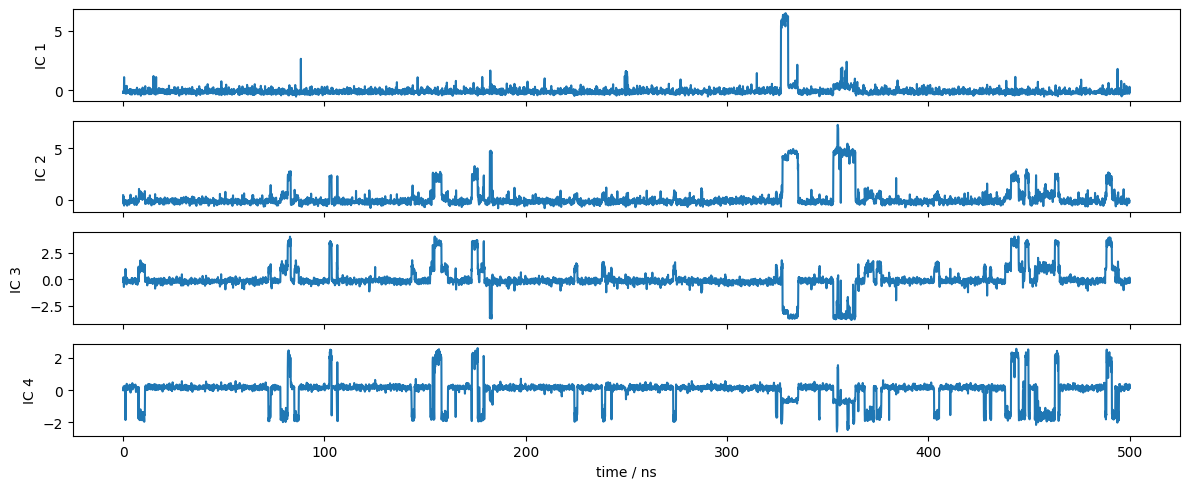

In [9]:

fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()


In [10]:

cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%|          | 0/75 [00:00<?, ?it/s]c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
100%|██████████| 50/50 [00:00<00:00, 138.88it/s]

13-06-24 12:59:17 pyemma.coordinates.clustering.kmeans.KmeansClustering[3547] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.



100%|██████████| 25/25 [00:00<00:00, 219.79it/s]                                    


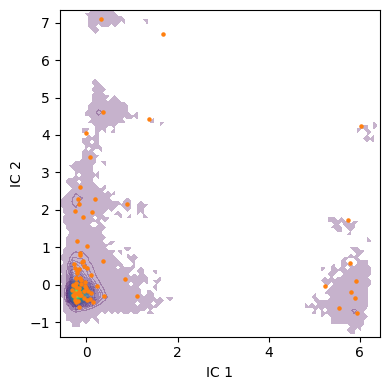

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]                        


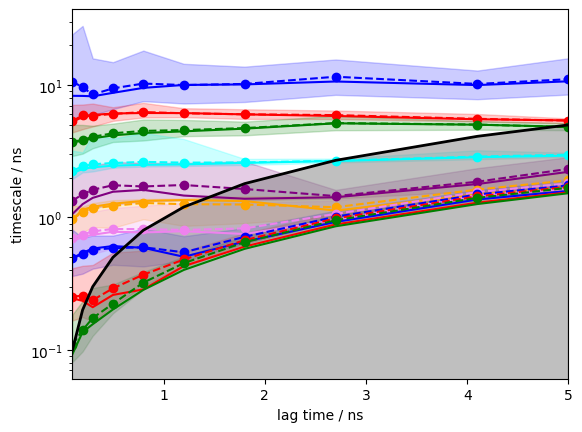

In [12]:
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);


In [13]:

msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))


100%|██████████| 100/100 [00:00<00:00, 112.41it/s]                                                                    

fraction of states used = 1.00
fraction of counts used = 1.00


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]                        


TypeError: legend() takes 0-2 positional arguments but 3 were given

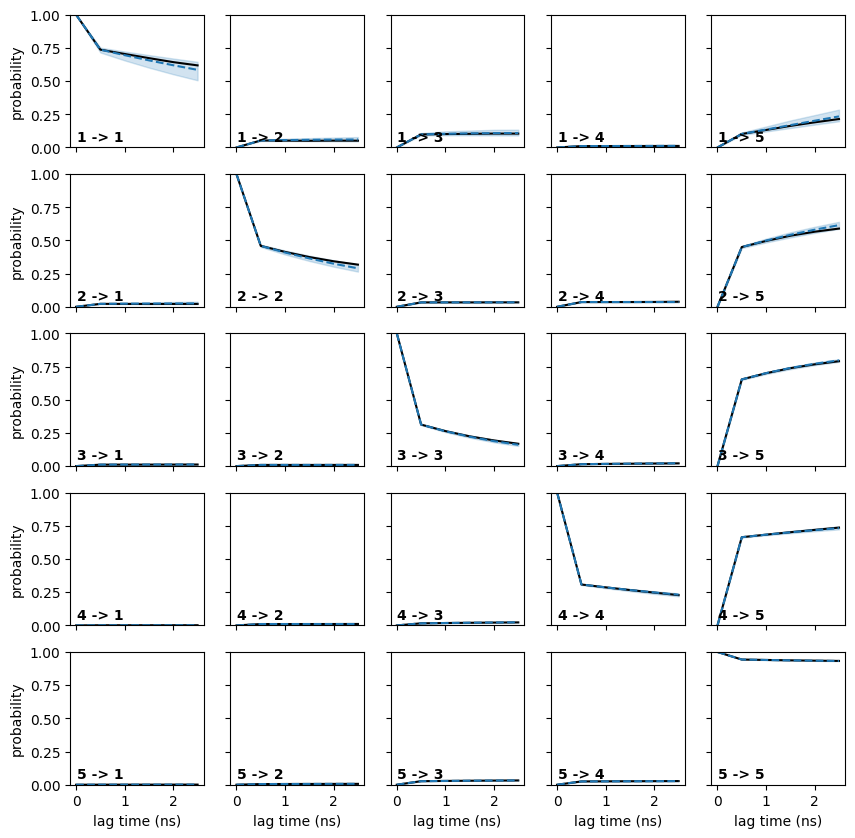

In [18]:
nstates = 5
msm.pcca(nstates)

# Realitzar el test de Chapman-Kolmogorov
cktest = msm.cktest(nstates, mlags=6)

# Visualitzar els resultats del test de Chapman-Kolmogorov
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')
plt.show()


ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of labels (16).

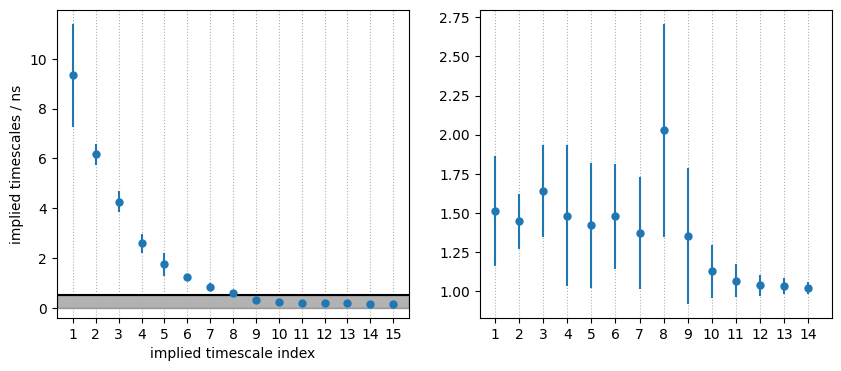

In [ ]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()


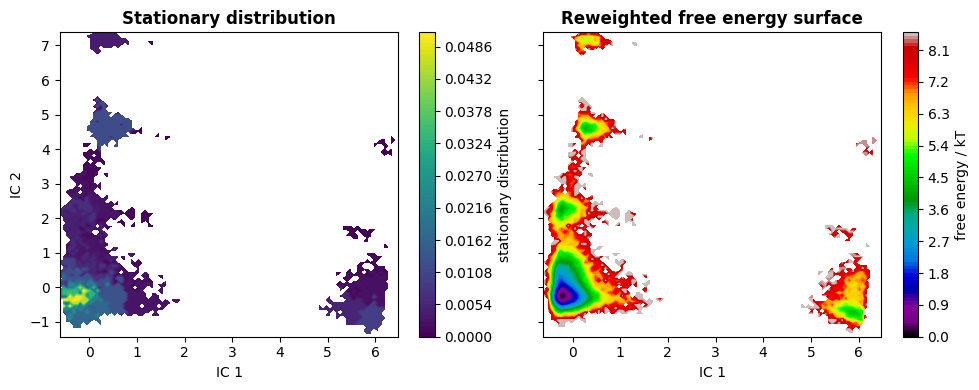

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()


The first eigenvector is one: True (min=0.9999999999999967, max=1.0000000000000169)


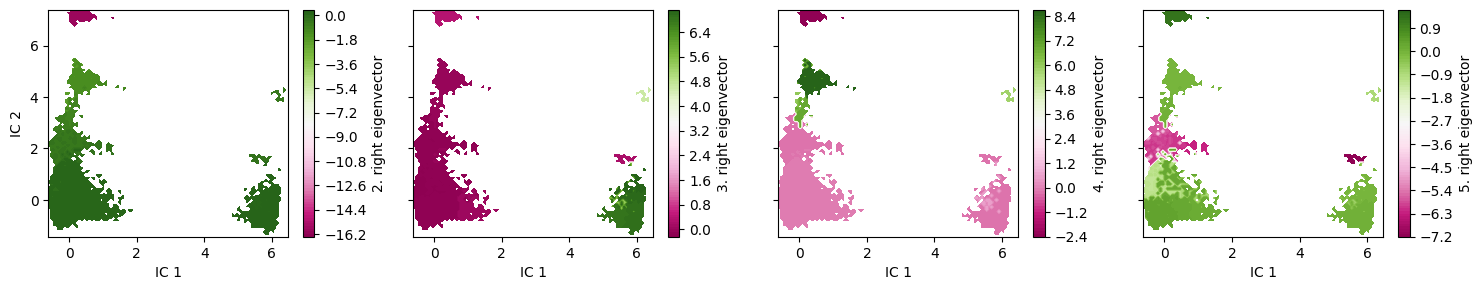

In [20]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()


In [21]:
msm.pcca(nstates)


PCCA-1677398199936:[{'P': array([[1.03806228e-01, 0.00000000e+00, 0.00000000e+00, ...,
                           0.00000000e+00, 1.64172225e-03, 0.00000000e+00],
                          [0.00000000e+00, 1.95924765e-02, 6.35744514e-04, ...,
                           4.52336424e-04, 4.86326408e-02, 5.83109373e-03],
                          [0.00000000e+00, 5.61369100e-04, 8.03631472e-01, ...,
                           0.00000000e+00, 3.17280792e-03, 5.68351652e-04],
                          ...,
                          [0.00000000e+00, 7.52026872e-03, 0.00000000e+00, ...,
                           1.29870130e-02, 1.30280763e-02, 0.00000000e+00],
                          [9.18162895e-05, 1.17605036e-02, 8.68912342e-04, ...,
                           1.89498843e-04, 4.80531814e-02, 6.35071308e-03],
                          [0.00000000e+00, 1.19462038e-02, 1.31865487e-03, ...,
                           0.00000000e+00, 5.38027313e-02, 4.78468900e-03]]),
                    'm':

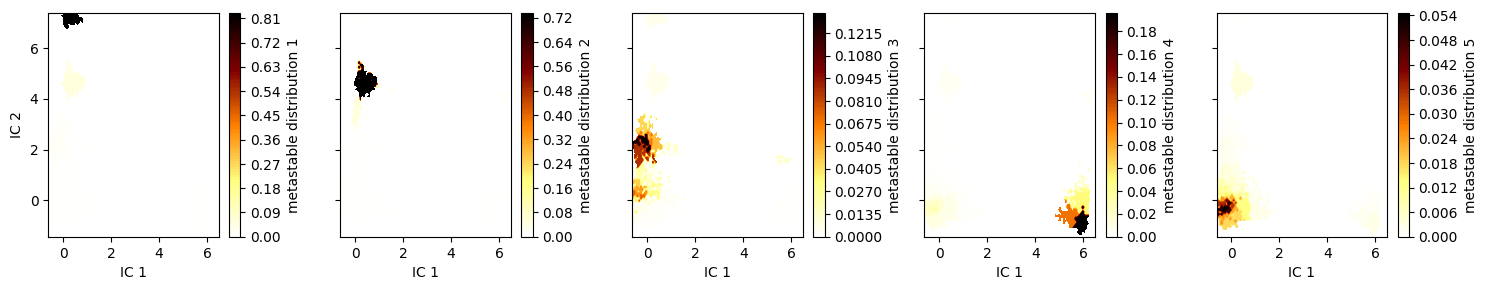

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()


ImportError: cannot import name 'get_cmap' from 'matplotlib.cm' (c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cm.py)

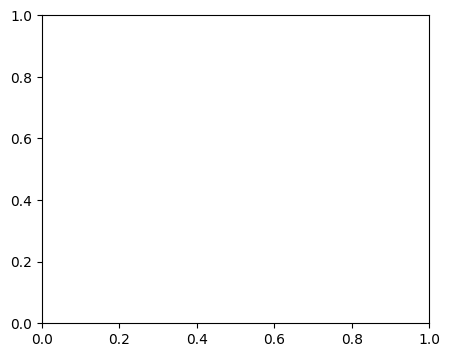

In [25]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
